**Homework 4 - Part 2**

##MNIST Classifier with training knobs using keras 


Implemented:<br/>
Mini Batch Gradient Descent<br/>
Dropout<br/>
Image Augmentation<br/>
3 layers for training<br/>
Relu activation layer in training<br/>
Normalized the input before training<br/>
Learning rate<br/>
Confusion metrics<br/>
Visualizations<br/>
Top common errors<br/>

In [11]:
import sys, numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Load the image data set

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Some examples of the input data

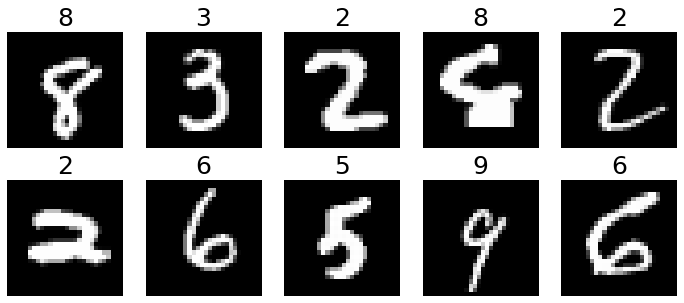

In [7]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

**Data Augmentation using ImageDataGenerator**

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(x_train)
train_augmentation = datagen.flow(x_train.reshape(-1,28,28,1), y=y_train)

batch_index = 0
x_list, y_list = [], []
while batch_index <= train_augmentation.batch_index:
    data = train_augmentation.next()
    x_list.append(data[0])
    y_list.append(data[1])
    batch_index = batch_index + 1
x_augmentation = np.asarray(x_list).reshape(-1,28, 28)
y_augmentation = np.asarray(y_list).reshape(-1, )

**Normalizing the input and converting the data using one hot encoding**

In [9]:
#images, labels = (x_train[0:1000].reshape(1000,28*28) / 255, y_train[0:1000])
def hot_labels(labels):
  one_hot_labels = np.zeros((len(labels),10))
  for i,l in enumerate(labels):
      one_hot_labels[i][l] = 1
  return one_hot_labels


images, labels = (x_augmentation[0:60000].reshape(60000,28*28) / 255, y_augmentation[0:60000])
labels = hot_labels(labels)
x, y_true = images, labels

test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = y_test
#test_labels = np.zeros((len(y_test),10))
test_labels = hot_labels(test_labels)
x_test, y_test = test_images, test_labels
print(f'images: {images.shape}, labels: {labels.shape}, test_images: {test_images.shape}, test_labels: {test_labels.shape}')

images: (60000, 784), labels: (60000, 10), test_images: (10000, 784), test_labels: (10000, 10)


**Build the neural network model using keras and dropout rate**

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import tensorflow as tf

model = tf.keras.Sequential(
    [
    tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])


In [26]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

**Using categorical crossentropy as loss function**

In [27]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 32


In [28]:
# Fit the model
history = model.fit(x, y_true, steps_per_epoch=6000, epochs=epochs, callbacks=[learning_rate_reduction])
                              

Epoch 1/10
6000/6000 [==============================] - 148s 24ms/step - loss: 0.4732 - accuracy: 0.8482
Epoch 2/10
6000/6000 [==============================] - 145s 24ms/step - loss: 0.1721 - accuracy: 0.9528
Epoch 3/10
6000/6000 [==============================] - 147s 25ms/step - loss: 0.1492 - accuracy: 0.9624
Epoch 4/10
6000/6000 [==============================] - 145s 24ms/step - loss: 0.1426 - accuracy: 0.9645
Epoch 5/10
6000/6000 [==============================] - 145s 24ms/step - loss: 0.1375 - accuracy: 0.9671
Epoch 6/10
6000/6000 [==============================] - 147s 25ms/step - loss: 0.1423 - accuracy: 0.9682
Epoch 7/10
6000/6000 [==============================] - 148s 25ms/step - loss: 0.1439 - accuracy: 0.9687
Epoch 8/10
6000/6000 [==============================] - 146s 24ms/step - loss: 0.1317 - accuracy: 0.9713
Epoch 9/10
6000/6000 [==============================] - 148s 25ms/step - loss: 0.1319 - accuracy: 0.9718
Epoch 10/10
6000/6000 [==============================] 

**Evaluating the Model**

In [33]:
model.evaluate(x_test, y_test,batch_size=32, verbose=1)

313/313 [==============================] - 5s 16ms/step - loss: 0.0672 - accuracy: 0.9908


[0.0672411397099495, 0.9908000230789185]

**Confusion Matrix**

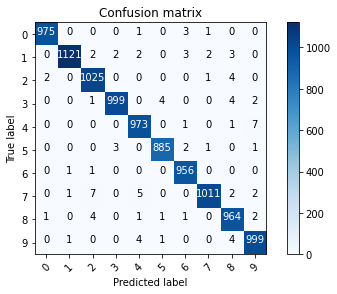

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Predict the values from the validation dataset
Y_pred = model(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

**Displaying top common errors**

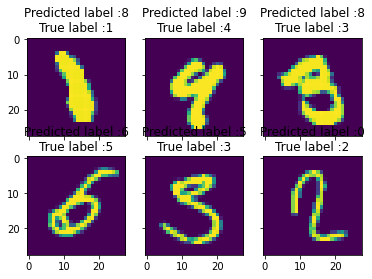

In [37]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

            
# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

Reference: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6